In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os
import copy
import emcee
import corner

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic
from scipy.signal import medfilt

from astropy.coordinates import HeliocentricMeanEcliptic, HeliocentricTrueEcliptic, SkyCoord

from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body

import sunpy.coordinates


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
EITmetadata = Table.read("./EIT/EITresults/EIT_headerMetadata.txt",format="ascii")
print(np.shape(EITmetadata))
print(EITmetadata.colnames)


(91883,)
['DATE-BEG', 'DATE-AVG', 'XPOSURE', 'CMDXPOS', 'SHUTCLS', 'FILTER', 'WAVELNTH', 'OBJECT', 'SCI_OBJ', 'OBS_PROG', 'CMP_NO', 'UCD', 'EXPMODE', 'LYNESYNC', 'ROUTPORT', 'NLEBPROC', 'LEBPROC1', 'LEBPROC2', 'LEBPROC3', 'WCSNAME', 'CTYPE1', 'CTYPE2', 'CUNIT1', 'CUNIT2', 'PC1_1', 'PC1_2', 'PC2_1', 'PC2_2', 'CDELT1', 'CDELT2', 'CRVAL1', 'CRVAL2', 'CRPIX1', 'CRPIX2', 'CROTA', 'CFTEMP', 'CCDTEMP', 'SOLAR_B0', 'RSUN_ARC', 'RSUN_OBS', 'RSUN_REF', 'CAR_ROT', 'DSUN_OBS', 'SC_X0', 'SC_Y0', 'SC_ROLL', 'HAEX_OBS', 'HAEY_OBS', 'HAEZ_OBS', 'HI-LAT-DEG', 'HI-LON-DEG']


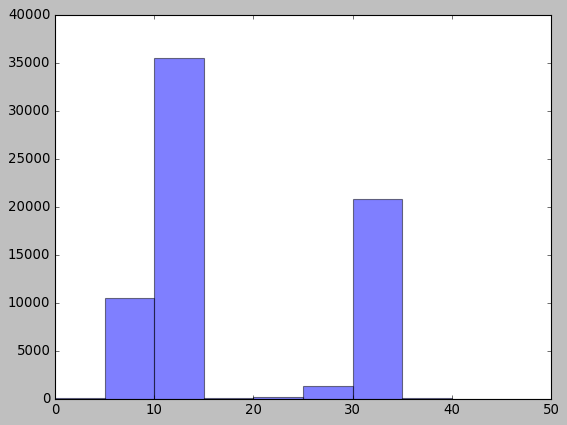

In [7]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.hist(EITmetadata['XPOSURE'], range=(0,50),bins=10, color='b', alpha=0.5)
plt.show()

In [8]:
print(np.min(EITmetadata['XPOSURE']))
print(np.max(EITmetadata['XPOSURE']))
print(EITmetadata['XPOSURE'])

2.1
602.1
XPOSURE
-------
   6.35
  602.1
   12.1
 82.944
  102.1
   12.1
   12.1
   12.1
  302.1
   22.1
    ...
 12.598
 32.596
 12.597
 12.597
 33.992
 12.595
 12.595
122.594
 12.591
 32.771
Length = 91883 rows


In [7]:
HAEcoords = SkyCoord(frame='heliocentricmeanecliptic',
                     x=EITmetadata['HAEX_OBS']*u.m, 
                     y=EITmetadata['HAEY_OBS']*u.m,
                     z=EITmetadata['HAEZ_OBS']*u.m, 
                     representation_type='cartesian',
                     obstime=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'),
                     equinox=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'))
                     #equinox='J2000')
print(HAEcoords)
HIcoords = HAEcoords.transform_to(sunpy.coordinates.frames.HeliocentricInertial())
print(HIcoords)
#HTEcoords = HAEcoords.transform_to(HeliocentricTrueEcliptic(equinox=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'))).cartesian
#print(HTEcoords)

<SkyCoord (HeliocentricMeanEcliptic: equinox=[2450098.53667712 2450098.51294675 2450099.07992046 ... 2459945.04670441
 2459944.55117249 2459944.55538405], obstime=[2450098.53667712 2450098.51294675 2450099.07992046 ... 2459945.04670441
 2459944.55117249 2459944.55538405]): (x, y, z) in m
    [(-6.4908808e+10, 1.30562576e+11, -77407740.),
     (-6.4908808e+10, 1.30562576e+11, -77407740.),
     (-6.4908808e+10, 1.30562576e+11, -77407740.), ...,
     (-2.3997426e+10, 1.43888768e+11,  87906600.),
     (-2.2729508e+10, 1.44096144e+11,  88275190.),
     (-2.2747128e+10, 1.44093344e+11,  88270380.)]>
<SkyCoord (HeliocentricInertial: obstime=[2450098.53667712 2450098.51294675 2450099.07992046 ... 2459945.04670441
 2459944.55117249 2459944.55538405]): (lon, lat, distance) in (deg, deg, m)
    [(40.49344787, -4.75368571, 1.45807221e+11),
     (40.49344878, -4.75368579, 1.45807221e+11),
     (40.4934271 , -4.75368388, 1.45807221e+11), ...,
     (23.21800666, -2.83997871, 1.45876186e+11),
     (22

In [18]:
print(HIcoords.lat.to(u.rad))
print(HIcoords.lat.to(u.deg))
print(HIcoords.lat.to(u.rad).value*(180./np.pi))
print(HIcoords.distance)

[-0.0829675 rad -0.0829675 rad -0.0829674 rad ... -0.049567 rad
 -0.048541 rad -0.0485553 rad]
[-4d45m13.26856214s -4d45m13.26884989s -4d45m13.26197476s ...
 -2d50m23.92336502s -2d46m52.30607686s -2d46m55.24966945s]
[-4.75368571 -4.75368579 -4.75368388 ... -2.83997871 -2.78119613
 -2.7820138 ]
[1.45807221e+11 1.45807221e+11 1.45807221e+11 ... 1.45876186e+11
 1.45877815e+11 1.45877796e+11] m


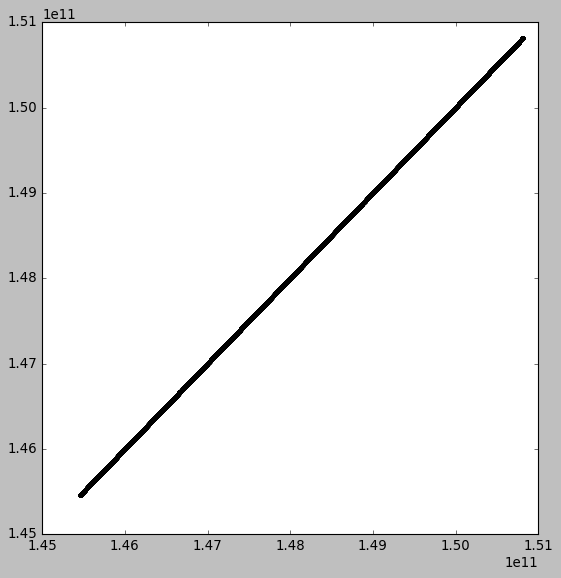

In [19]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(EITmetadata['DSUN_OBS'], HIcoords.distance.value, 'k.')
plt.show()

In [20]:
EITmetadata['HI-LAT-DEG'] = HIcoords.lat.to(u.rad).value*(180./np.pi)
EITmetadata['HI-LON-DEG'] = HIcoords.lon.to(u.rad).value*(180./np.pi)


In [21]:
ascii.write(EITmetadata, "./EIT/EITresults/EIT_headerMetadata.txt", overwrite=True) 